# Research with pipelines



This tutorial demonstrate how to work with pipeline in Research.

### Imports and Utilities

We start with some useful imports and constant definitions

In [1]:
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../..')

import matplotlib.pyplot as plt
%matplotlib inline

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.research import Research, Domain, E
from batchflow.models.torch import VGG7, VGG16
from batchflow.models.metrics import Loss

In [2]:
BATCH_SIZE = 64
ITERATIONS = 50
CHANNELS = 'last'

### Single-experiment Research

First we define a simple pipeline that loads some MNIST data and trains VGG7 model on it. It also saves the loss on each iteration in a pipeline variable. Let's call it an experiment.

### Loading Data and Creating Pipeline

We call a lazy version of pipeline's run method to define batch size to use. We pass `n_epochs=None`, because the duration of our experiment will be controlled by Research.

In [3]:
mnist = MNIST()

model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('conv', VGG7, 'dynamic', config=model_config)
            .to_array(channels=CHANNELS)
            .train_model('conv', images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

### Creating Research

The simpliest thing we can do with Research is running this experiment several times to see how loss dynamics changes from run to run.

To do this we define a `Research` object, pass the number of experiment iterations `n_reps=4` via initialization and add the pipeline with `add_pipeline`, passing `train_ppl`. The `variables` parameter gets a string or a list of strings that indicates which pipeline variables will be monitored by `Research` and written to research results on each iteration (note that we update loss variable with mode `'w'`). We also provide name that will be written to results, indicating their origin.

In [4]:
research = (Research(n_reps=4)
    .add_pipeline('train_ppl', train_ppl, variables='loss')
)

### Running Research

We run this Research with following parameters:
    
- n_iters - how many iterations will the experiment consist of. Each iteration here consists of processing a single batch
- name - research name, also acts as a name for corresponding save folder
- bar - toggles tqdm progress bar
- dump_results - not to dump research results

In [5]:
research.run(name='research', n_iters=ITERATIONS, bar=True, dump_results=False)

0it [00:00, ?it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 25%|██▌       | 50/200 [00:05<00:15,  9.81it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 50%|█████     | 100/200 [00:09<00:09, 10.27it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 75%|███████▌  | 150/200 [00:14<00:04, 10.21it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
100%|██████████| 200/200 [00:19<00:00, 10.06it/s]


### Investigating Research Results

In [6]:
results = research.results.to_df(remove_auxilary=False, pivot=True)
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          200 non-null    object 
 1   repetition  200 non-null    object 
 2   updates     200 non-null    object 
 3   device      200 non-null    object 
 4   iteration   200 non-null    int64  
 5   loss        200 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.9+ KB


In [7]:
results.sample(10)

,id,repetition,updates,device,iteration,loss
64,d7fc81d049534914,1,0,None,14,0.863032
35,b8c9f03130430383,0,0,None,35,0.387364
92,d7fc81d049534914,1,0,None,42,0.421826
146,b80801d305613302,2,0,None,46,0.383647
32,b8c9f03130430383,0,0,None,32,0.537315
65,d7fc81d049534914,1,0,None,15,0.668876
49,b8c9f03130430383,0,0,None,49,0.285996
9,b8c9f03130430383,0,0,None,9,1.082449
134,b80801d305613302,2,0,None,34,0.302029
115,b80801d305613302,2,0,None,15,0.549818


<AxesSubplot:xlabel='iteration'>

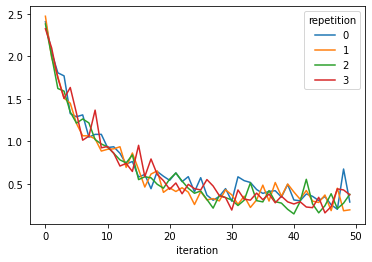

In [8]:
results.pivot(index='iteration', columns='repetition', values='loss').plot()

### Experiments with Domain

In [9]:
domain_1 = Domain(layout=['cna', 'can'], model=[VGG7, VGG16], bias=[False], stride=[2])
domain_2 = (Domain(layout=['cna'], bias=[True])
            * (Domain(model=[VGG7, VGG16]) @ Domain(stride=[1, 2])))
domain = domain_1 + domain_2
list(domain.iterator)

[{'bias': 'False',
  'layout': 'cna',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'cna',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'can',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'False',
  'layout': 'can',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'},
 {'bias': 'True',
  'layout': 'cna',
  'model': 'VGG7',
  'repetition': '0',
  'stride': '1',
  'updates': '0'},
 {'bias': 'True',
  'layout': 'cna',
  'model': 'VGG16',
  'repetition': '0',
  'stride': '2',
  'updates': '0'}]

In [10]:
model_config.update({
    'body/block/layout': C('layout'),
    'body/block/pool_strides': C('stride'),
    'common/conv/bias': C('bias')
})

# For reference: previous train_template definition 
# train_template = (Pipeline()
#             .init_variable('loss')
#             .init_model('conv', VGG7, 'dynamic', config=model_config)
#             .to_array(channels=CHANNELS)
#             .train_model('conv', images=B('images'), targets=B('labels'),
#                          fetches='loss', save_to=V('loss', mode='w'))
#             .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_template = (Pipeline()
            .init_variable('loss', default=[])
            .init_model('conv', C('model'), 'dynamic', config=model_config) # Model class defined via named expression
            .to_array(channels=CHANNELS)
            .train_model('conv', 
                         images=B('images'), targets=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

train_ppl = train_template << mnist.train

In [11]:
research = (Research(domain=domain, n_reps=2)
            .add_pipeline('train', train_ppl, variables='loss'))

research.run(n_iters=ITERATIONS, bar=True, dump_results=False)

0it [00:00, ?it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
  8%|▊         | 50/600 [00:04<00:52, 10.41it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 17%|█▋        | 100/600 [00:10<00:51,  9.75it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 25%|██▌       | 150/600 [00:15<00:45,  9.87it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n_epochs=None and n_iters=None', RuntimeWarning)
 33%|███▎      | 200/600 [00:21<00:42,  9.49it/s]../../../batchflow/base.py:182: RuntimeWarning: Batch generation will never stop as n_epochs=None and n_iters=None
  'n

In [12]:
results = research.results.to_df(remove_auxilary=False, pivot=True)
results.head()

,id,layout,model,bias,stride,repetition,updates,device,iteration,loss
0,e9846ea030430383,cna,VGG7,False,2,0,0,None,0,2.432178
1,e9846ea030430383,cna,VGG7,False,2,0,0,None,1,1.966481
2,e9846ea030430383,cna,VGG7,False,2,0,0,None,2,1.642050
3,e9846ea030430383,cna,VGG7,False,2,0,0,None,3,1.502047
4,e9846ea030430383,cna,VGG7,False,2,0,0,None,4,1.249028


### Controlling `to_df` output

#### Loading Results With Single-column Config Representation

To combine different config options in a single-column string representation we can pass `concat_config=True` to `to_df` method.

In [13]:
results = research.results.to_df(concat_config=True, remove_auxilary=False, pivot=True)
results.head()

,id,config,repetition,updates,device,iteration,loss
0,e9846ea030430383,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,0,2.432178
1,e9846ea030430383,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,1,1.966481
2,e9846ea030430383,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,2,1.642050
3,e9846ea030430383,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,3,1.502047
4,e9846ea030430383,bias_False-layout_cna-model_VGG7-stride_2,0,0,None,4,1.249028


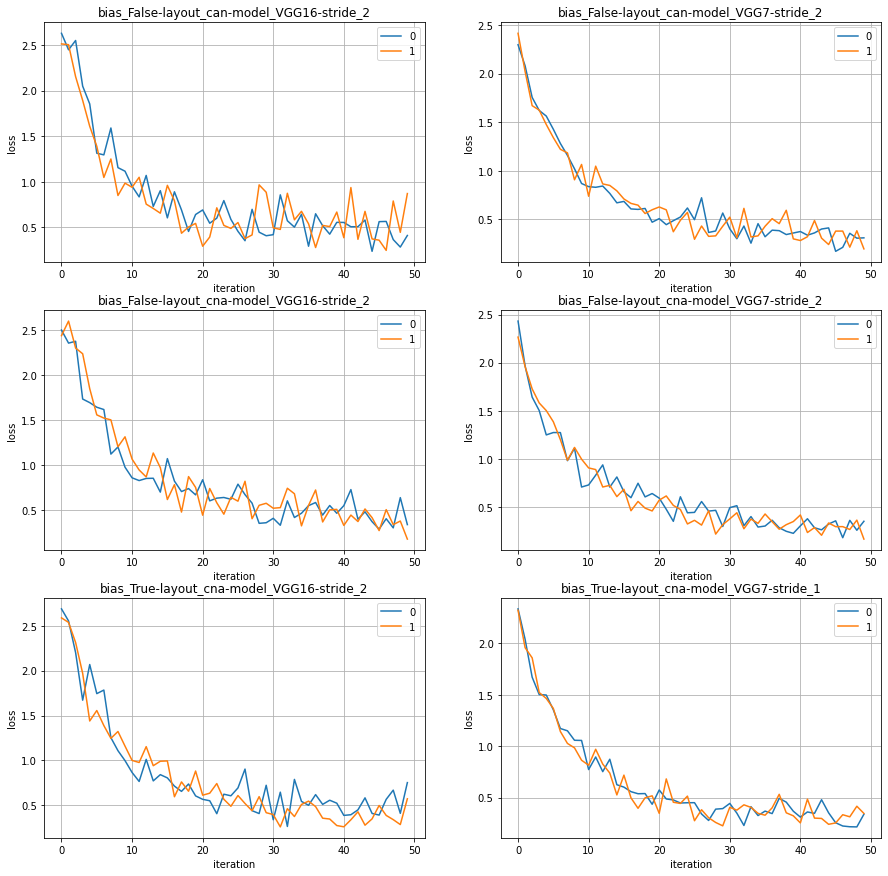

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, (config, df) in enumerate(results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='repetition', values='loss').plot(ax=ax[x, y])
    ax[x, y].set_title(config)
    ax[x, y].set_xlabel('iteration')
    ax[x, y].set_ylabel('loss')
    ax[x, y].grid(True)
    ax[x, y].legend()